##### <h3>USFWS Pea Island NWR Exploratory Bar plots (sand weight % by transect, by sample, by survey)  Plot Group 4</h3>


**--Supports:**<br />
transects=['C11','C10','C9','C8','C7','C6','C5','C4','C3','C2','C1','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10',
'T11','T12','T13','T14','T15','T16']

surveys=[201407, 201409, 201504, 201508, 201602, 201605, 201608, 201610 ]

phis=['phi-1','phi-0.5','phi_0','phi_0.5','phi_1','phi_1.25','phi_1.5','phi_1.75','phi_2','phi_2.5','phi_3','phi_3.5','phi_4','remainder']

samples=['S1','S2','S3','S5','S4']
<br /><br />
--Notebook circa: 10/2016
Updated for new project and data format standards from original: 9/2020
Author: Paul P

<br />
**Instructions:**
To generate plots:
    1. Enter: datapath, fn (source file name), survey, and sample ids and plotpath in the 'User Inputs' cell below
    2. Under the menu Cell select Run All
    
    
**Notes:**
1. Lines commented with three asterisks are older sections that were used to read sediment data from sources prior to spreadsheet standardization...


**Changes:**
1. Adapted notebook to read source sediment data from Excel spreadsheets: 3/28/2017
2. Adapted notebook for github repo posting and presentation: 3/30/2017


<br />
--keywords: Python, pandas, matplotlib, bar plot, median, sand sediment grain size analysis, Pea Island, North Carolina

<h4>Load requisite modules and libraries</h4>

In [139]:
# import requiste Python libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

<h4>User Inputs: These are required!!!</h4>

In [151]:
####################################################################################
#datapath='/Users/paulp/GoogleDrive/projects/PeaIslandBeachMonitoring/data/xls/' # where your data is stored...
datapath='../../../data/2020_data/'
fn='PINWR_201407_GrainSizeWeights.csv' #'PINWR_JAN2020_SieveData.xlsx'         # excel spreadsheet

# optional, 
controls_sheet = 'GrainSize_Control'
treatment_sheet = 'GrainSize_Treatment'

survey='201407'
sample='S4'

plotpath='../../../plots_n_graphics/plotGroup4/' # where your plots end up...
####################################################################################

<h4>Load the data from the source spreadsheet to a pandas dataframe:</h4>

In [141]:
# load the plotting data (the data to be plotted) to a pandas dataframe:

df_c = pd.read_excel(datapath+fn, sheet_name=controls_sheet, skiprows=0).fillna(0)
df_t = pd.read_excel(datapath+fn, sheet_name=treatment_sheet, skiprows=0).fillna(0)

# use the following lines to read from source: 'USFWS_Survey_Plotting_Data.csv'  
# *** hdr=['group','transect','sample','survey','phi_-1','phi_-0.5','phi_0','phi_0.5','phi_1','phi_1.25','phi_1.5', \
# ***'phi_1.75','phi_2','phi_2.5','phi_3','phi_3.5','remainder']
# *** df=pd.read_csv(path+fn, names=hdr ).fillna(0) 


<h4>Data Scrub: Clean up and modify the control and treatment data frames to facilitate later processing, then
concatenate into a single dataframe: df</h4>

In [142]:
# 1.) drop any rows where the transect ID is empty or set to 0 - these are extraneous rows from Excel:
try:
    df_c.drop( df_c.loc[df_c['transect_ID']== 0].index, inplace=True)
    print('dropping rows from Controls with no data...')
except Exception as e:
    print('Oops!', e)

try:
    df_t.drop( df_t.loc[df_t['transect_ID']== 0].index, inplace=True)
    print('dropping rows from Treatments with no data...')
except Exception as e:
    print('Oops!', e)

    
# 2.) drop columns that we don't need:
try:
    df_c = df_c.drop(['sheet_code','NET LOSS (g)','CV (%)','(-2.00Φ)+(-1.00Φ)',
               'DISH+DRY WT (g)','WET WT (g)','DISH WT (g)','DRY WT (g)'], axis=1)
    print('dropping unneeded columns from Controls...')
except Exception as e:
    print('Oops!', e)

try:
    df_t = df_t.drop(['sheet_code','NET LOSS (g)','CV (%)','(-2.00Φ)+(-1.00Φ)',
               'DISH+DRY WT (g)','WET WT (g)','DISH WT (g)','DRY WT (g)'], axis=1)
    print('dropping unneed columns from Treatments...')
except Exception as e:
    print('Oops!', e)

    
# 3.) create an entry for a fictious control transect C00. This is inserted so that we can include
# a gap in the bars between the control and treatment transect data in the plot to come later
dummy_line = pd.DataFrame({'transect_ID':'C00','sample_ID':sample, '-2.00Φ':0, '-1.00Φ':0,'-0.50Φ':0, '0Φ':0,
                           '0.5Φ':0, '1.00Φ':0,'1.25Φ':0,'1.50Φ':0,'1.75Φ':0,'2.00Φ':0,'2.50Φ':0,'3.00Φ':0,
                           '3.50Φ':0,'PAN':0, 'ΣSIEVED WT (g)':0}, index=[0])

df_c = pd.concat([dummy_line, df_c], ignore_index=True)
                 
                 
                 
# 4.) sort the control data in descending order
df_c.sort_values(by=['transect_ID'], ascending=False, inplace=True)


# 5.) finally, and at last, concatentate the two data frames into one: df
df = pd.concat([df_c, df_t], ignore_index=True)

dropping rows from Controls with no data...
dropping rows from Treatments with no data...
dropping unneeded columns from Controls...
dropping unneed columns from Treatments...


<h4>Data Preprocessing I: (Adding a 'Group' field)</h4>

In [143]:
## create a populate new group column (field) based on transect id type (e.g., control or transect):
df.loc[df['transect_ID'].str[0] == 'C', 'Group'] ='control'
df.loc[df['transect_ID'].str[0] =='T', 'Group'] = 'treatment'

<h4>Data Preprocessing II: (Converting the absolute screen weights as read from the spreadsheet to fraction weight percentages)</h4>

In [145]:
### Convert screen absolute weights posted in the spreadsheets to weight percentages:

# -2.00Φ
# recompute the total weight of the samples, just in case the summed_weight field is flawed...
df['total_weight']=df[['-2.00Φ', '-1.00Φ','-0.50Φ', '0Φ','0.5Φ', '1.00Φ','1.25Φ','1.50Φ',
'1.75Φ','2.00Φ','2.50Φ','3.00Φ','3.50Φ','PAN']].sum(axis=1)

# recast the absolute screen weights to weight percent fractions: (This is meathead. There must be a better way!)
df['-2.00Φ'] = (df['-2.00Φ'] / df['total_weight'])*100
df['-1.00Φ'] = (df['-1.00Φ'] / df['total_weight'])*100
df['-0.50Φ'] = (df['-0.50Φ'] / df['total_weight'])*100
df['0Φ'] = (df['0Φ'] / df['total_weight'])*100
df['0.5Φ'] = (df['0.5Φ'] / df['total_weight'])*100
df['1.00Φ'] = (df['1.00Φ'] / df['total_weight'])*100
df['1.25Φ'] = (df['1.25Φ'] / df['total_weight'])*100
df['1.50Φ'] = (df['1.50Φ'] / df['total_weight'])*100
df['1.75Φ'] = (df['1.75Φ'] / df['total_weight'])*100
df['2.00Φ'] = (df['2.00Φ'] / df['total_weight'])*100
df['2.50Φ'] = (df['2.50Φ'] / df['total_weight'])*100
df['3.00Φ'] = (df['3.00Φ'] / df['total_weight'])*100
df['3.50Φ'] = (df['3.50Φ'] / df['total_weight'])*100
df['PAN'] = (df['PAN'] / df['total_weight'])*100

df

,transect_ID,sample_ID,-2.00Φ,-1.00Φ,-0.50Φ,0Φ,0.5Φ,1.00Φ,1.25Φ,1.50Φ,1.75Φ,2.00Φ,2.50Φ,3.00Φ,3.50Φ,PAN,ΣSIEVED WT (g),Group,total_weight
0,C11,S5,0.000000,0.000000,0.000000,0.000000,0.030463,0.436637,3.818034,10.966694,23.456539,35.387896,20.765638,4.599919,0.538180,0.000000,98.48,control,98.48
1,C11,S4,0.000000,0.000000,0.000000,0.000000,0.064091,1.199414,3.396814,7.095770,13.660502,24.601721,26.139901,17.377770,6.271745,0.192272,109.22,control,109.22
2,C11,S3,0.138628,0.703040,5.654025,14.268739,15.100505,12.535895,5.693633,5.505496,7.347262,11.070403,15.892663,5.455986,0.613922,0.019804,100.99,control,100.99
3,C11,S2,0.000000,0.640823,1.938291,3.639241,7.531646,16.685127,9.287975,11.289557,12.444620,16.495253,15.878165,3.797468,0.356013,0.015823,126.40,control,126.40
4,C11,S1,9.135083,12.080437,12.259849,12.626149,11.288032,10.159229,3.737759,4.246094,5.023548,7.348434,9.030425,2.788368,0.239217,0.037378,133.77,control,133.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,T15,S4,0.106445,0.135475,0.512870,2.099865,8.147861,30.414167,20.834140,17.902071,13.547513,5.506096,0.764467,0.019354,0.000000,0.009677,103.34,treatment,103.34
130,T16,S1,41.848667,21.534824,7.601032,5.326741,5.206363,7.188306,3.490972,3.413586,2.476354,1.405847,0.438521,0.068788,0.000000,0.000000,232.60,treatment,232.60
131,T16,S2,5.945403,6.403171,5.202925,7.703902,11.963379,22.609278,15.753922,11.773572,7.374532,3.572824,1.138838,0.508011,0.050243,0.000000,179.13,treatment,179.13
132,T16,S3,0.000000,0.041009,0.266557,0.943203,5.433668,28.009022,20.422391,19.930285,16.095961,7.033012,1.609596,0.215296,0.000000,0.000000,97.54,treatment,97.54


<h4>Data Preprocessing III: (Selecting the sample data of interest from the dataframe and aggregating to simplify presentation)</h4>

In [146]:
### CELL 4 ####
### Do the data munging to select, sort, group and re-configure the data into a form and
### format useful to further analysis:

# dfs = df subset for current sample

query_string = 'sample_ID == '+'\"'+sample+'\"'
dfs = df.query(query_string).groupby(['transect_ID'], sort=False, as_index=False).sum()
# *** df1 = df1.drop(['survey'], axis=1)    

# next we're going to aggregate some of the screens to simplify the plots (for interpretation)
# We'll combine the -0.5 and 0 phi fractions; we'll also combine the 0.5 and 1.0 fractions, and the 
# 1.25, 1.5, 1.75, and 2.0 phi fractions. Then, we bring together the 2.5 and 3.0 fractions, and finally
# merge the 3.5 and remainder.

dfs['gravel'] = dfs['-2.00Φ'] + dfs['-1.00Φ']  # gravel
 
dfs['very coarse sand'] = dfs['-0.50Φ'] + dfs['0Φ']       # very coarse sand
dfs['coarse sand'] = dfs['0.5Φ'] + dfs['1.00Φ']      # coarse sand

dfs['medium sand'] = dfs['1.25Φ'] + dfs['1.50Φ'] + dfs['1.75Φ'] + dfs['2.00Φ']   # medium sand
 
dfs['fine sand'] = dfs['2.50Φ'] + dfs['3.00Φ']    # (fine sand)
 
dfs['very fine sand'] = dfs['3.50Φ'] + dfs['PAN']     # very fine sand + slit + clay

# re-organize the data to remove the fractional phis (1.25, 1.5, 1.75 and the old 2.0), then 
# shift the newphi_2 field to position between phi_1 and phi_2.5...
dfs = dfs.drop(['-2.00Φ', '-1.00Φ', '-0.50Φ','0Φ', '0.5Φ','1.00Φ','1.25Φ','1.50Φ','1.75Φ',
               '2.00Φ','2.50Φ','3.00Φ','3.50Φ','PAN','total_weight'], axis=1)

# rename the ΣSIEVED WT (g) field to total total sample wt for simpler ops:
dfs.rename(columns={'ΣSIEVED WT (g)': 'total sample wt'}, inplace=True)

__Plot the Pea Island Beach Samples__

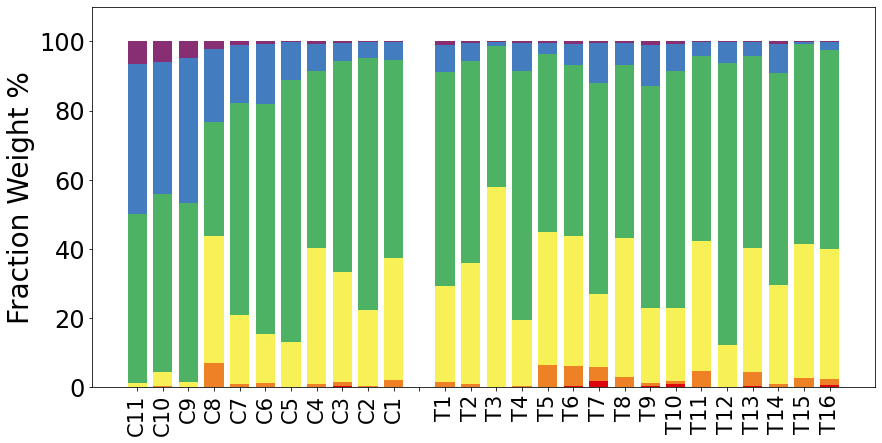

In [148]:
### CELL 5 ####
####### LET'S PLOT SOMETHING #######

f, ax1 = plt.subplots(1, figsize=(15,7))
plt.gcf().subplots_adjust(right=0.85)
#plt.tight_layout()

# Set the bar width
bw = 0.75

# positions of the left bar-boundaries  (bar_l is the position of the left edge of each bar)
bar_l = [i+1 for i in range(len(dfs['gravel']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i for i in bar_l] 
#+(bw/28)
#phis=['phi_-1','phi_-0.5','phi_0','phi_0.5','phi_1','phi_1.25','phi_1.5','phi_1.75','phi_2','phi_2.5','phi_3','phi_3.5','remainder']
phis=['gravel','very coarse sand','coarse sand','medium sand','fine sand','very fine sand']
transects=['C11','C10','C9','C8','C7','C6','C5','C4','C3','C2','C1',' ','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12','T13','T14','T15','T16']
labs=['Gravel','Very Coarse Sand','Coarse Sand','Medium Sand','Fine Sand','Very Fine Sand']

# calc bottom positions for each sand fraction bar segment (it's a giant list!):
# there must be a more elegant way to do this, but time is of the essence, so 'meathead' it is, for now...
bots=[0, dfs['gravel'],
[i+j for i,j in zip(dfs['gravel'],dfs['very coarse sand'])],
[i+j+k for i,j,k in zip(dfs['gravel'],dfs['very coarse sand'],dfs['coarse sand'])],
[sum(values) for values in zip(dfs['gravel'],dfs['very coarse sand'],dfs['coarse sand'],
                               dfs['medium sand'])],
[sum(values) for values in zip(dfs['gravel'],dfs['very coarse sand'],dfs['coarse sand'],
                               dfs['medium sand'],dfs['fine sand'])]   
]

# set colors for the bar segments (rainbow):
colrs=['#dc050c','#ee8026','#f7f056','#4eb265','#437dbf','#882e72']

# and plot the thing!:
for phi, bot, colr, lab  in zip(phis, bots, colrs, labs):
    sbp=ax1.bar(bar_l, dfs[phi], width=bw, bottom=bot, label=lab, alpha=1, color=colr)

# set the x-axis ticks with names
plt.xticks(tick_pos, transects, size=21, rotation=90 )     # textsize 16pt for publication
plt.yticks(size=24)
plt.ylim(0,110)
plt.bbox_inches=2.0

# label the plot and (optionally) save a copy of the plotted figure:
#plt.xlabel('Transect')
plt.ylabel('Fraction Weight %', size=28)
#plt.title('Sample: '+sample+'  Survey: '+survey, size=24, position=([0.5,1.05])) 
#plt.legend(bbox_to_anchor=(1.15, 1.0))

plt.savefig(plotpath+sample+'_'+survey+'_'+'StackedWtPercentFractions.jpeg', res=300) 